# Про что этот ноутбук

В этом ноутбуке можно найти __три подхода__ к __сравнению__ двух __распределений данных__. Эти примеры детально разобраны - в них __шаг за шагом__ объясняется, как получить численную оценку, которая характеризует сходство или различие данных.
- Population stability Index (PSI)
- Критерий Колмогорова-Смирнова
- Adversarial Validation Score

_____
- *Этот ноутбук так же использовался для написания статьи https://habr.com/ru/companies/ru_mts/articles/817483/*
- *В telegram есть еще много чего интересного https://t.me/+HdRZec7VJEVlNmVi*
_____

In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, kstest
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [3]:
plt.rcParams.update({'font.size': 15})

In [4]:
import scipy
print(scipy.__version__)

import numpy
print(numpy.__version__)

import matplotlib
print(matplotlib.__version__)

import sklearn
print(sklearn.__version__)

1.11.4
1.25.2
3.8.2
1.3.2


# Population stability Index (PSI)
Пример расчета PSI на простом примере

In [42]:
arr_a = (beta.rvs(1, 2, 0, size=30))      # исходное распределение А
arr_b = (beta.rvs(1.9, 2.4, 0, size=30))  # исходное распределение Б

n_bins = 4
bins = np.linspace(min(arr_a.min(), arr_b.min()), max(arr_a.max(), arr_b.max()), n_bins+1)

### Оцениваем похожесть распределений

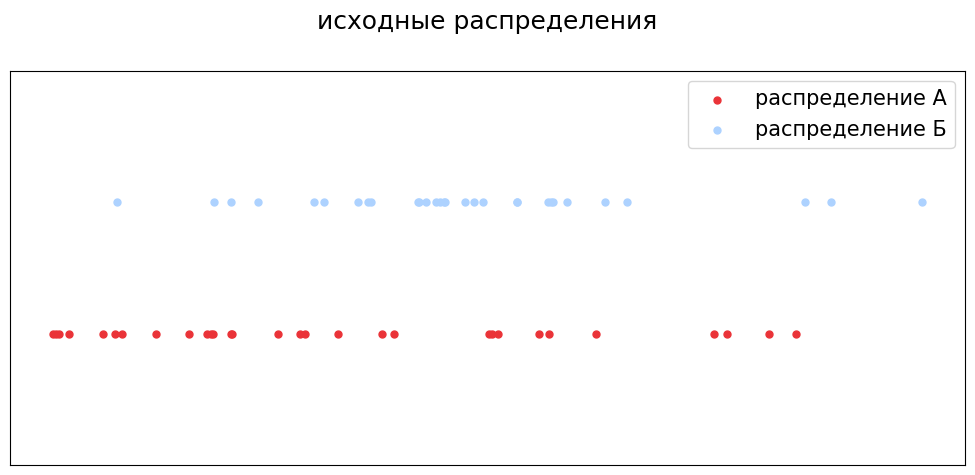

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axes.set_yticks([])
ax.axes.set_xticks([])

plt.scatter(arr_a, [0] * len(arr_a), color='#EA3338', label='распределение А', s=25)
plt.scatter(arr_b, [1] * len(arr_b), color='#ADD2FF', label='распределение Б', s=25)

plt.ylim(-1, 2)

plt.title('исходные распределения', pad=30)
plt.legend()

plt.tight_layout()
plt.savefig('../pictures/psi_1.png', dpi=100, format='png')

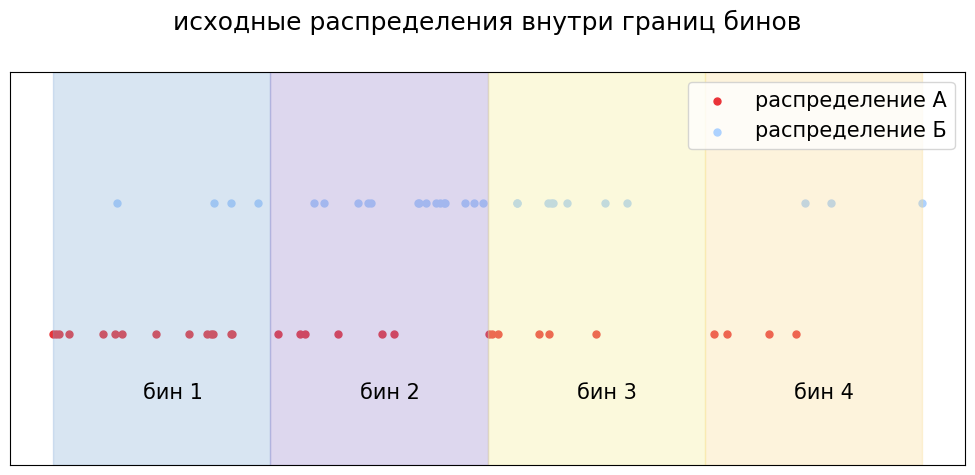

In [55]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axes.set_yticks([])
ax.axes.set_xticks([])

plt.scatter(arr_a, [0] * len(arr_a), color='#EA3338', label='распределение А', s=25)
plt.scatter(arr_b, [1] * len(arr_b), color='#ADD2FF', label='распределение Б', s=25)

plt.ylim(-1, 2)

colors = ["#81A9D7", "#8F7BC7", "#F3ED8C", "#F9D98B"]
for i in range(len(bins) - 1):
    ax.axvspan(bins[i], bins[i + 1], color=colors[i % len(colors)], alpha=0.3)
    ax.text(np.mean([bins[i], bins[i + 1]])-0.02, -0.5, f'бин {i+1}')

plt.title('исходные распределения внутри границ бинов', pad=30)
plt.legend()
plt.tight_layout()
plt.savefig('../pictures/psi_2.png', dpi=100, format='png')

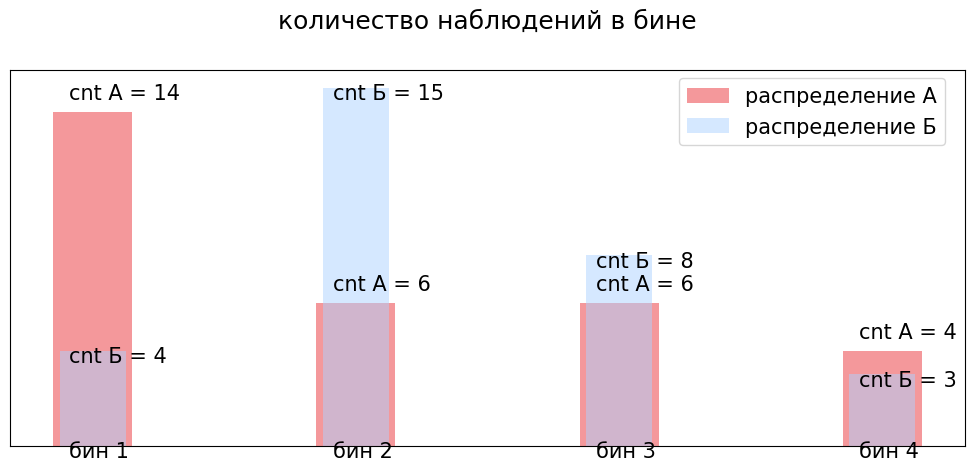

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axes.set_yticks([])
ax.axes.set_xticks([])

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

shift = 0.035

cnt_a = plt.hist(arr_a, bins=bins, color='#EA3338', rwidth=0.3, label='распределение А', alpha=0.5)
cnt_b = plt.hist(arr_b, bins=bins, color='#ADD2FF', rwidth=0.25, label='распределение Б', alpha=0.5)

plt.yticks([])
plt.xticks([])
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

plt.grid(False)
plt.tight_layout()
plt.legend(fontsize=15, loc=(0.7, 0.8))
plt.title('количество наблюдений в бине', pad=30)

for i in range(len(bins) - 1):
    ax.text(np.mean([bins[i], bins[i + 1]])-0.02, -0.5, f'бин {i+1}')
    ax.text(np.mean([bins[i], bins[i + 1]])-0.02, cnt_a[0][i]+0.5, f'cnt А = {cnt_a[0][i]:.0f}')
    ax.text(np.mean([bins[i], bins[i + 1]])-0.02, cnt_b[0][i]-0.5, f'cnt Б = {cnt_b[0][i]:.0f}')

plt.tight_layout()
plt.savefig('../pictures/psi_3.png', dpi=100, format='png')

Визуально оценили и поняли, что данные отличаются друг от друга

### Первый шаг в расчете PSI
- считаем попарно diff между бинами

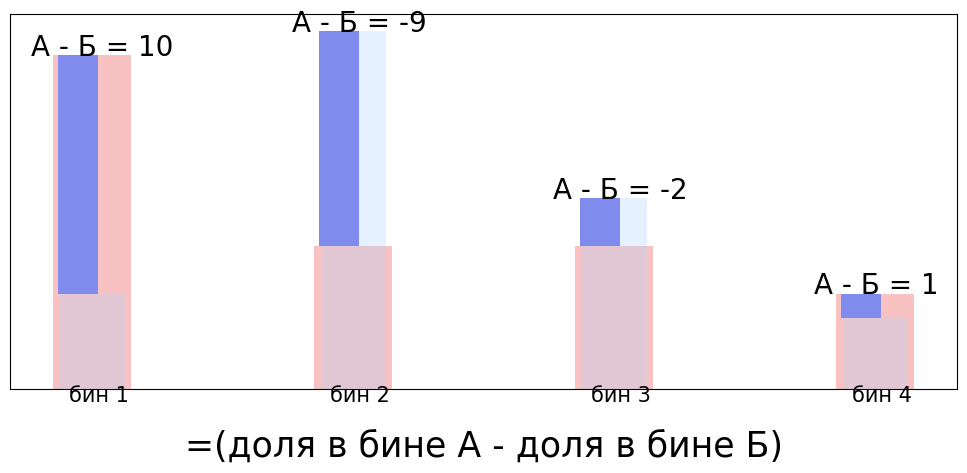

In [57]:
fig, ax = plt.subplots(figsize=(10, 5))
diff = arr_a - arr_b

plt.hist(arr_a, bins=bins, color='#EA3338', rwidth=0.3, label='распределение А', alpha=0.3)
plt.hist(arr_b, bins=bins, color='#ADD2FF', rwidth=0.25, label='распределение Б', alpha=0.3)

plt.title('=(доля в бине А - доля в бине Б)', fontsize=25, y=-0.2)
plt.bar(
    bins[: -1]+0.1
    , abs(cnt_a[0] - cnt_b[0])
    , bottom=np.min([cnt_a[0], cnt_b[0]], axis=0)
    , color='#808CED'
    , width=[shift] * (len(bins)-1)
    , alpha=1
    , label='bin_1 - bin_2'
)

for idx, diff in enumerate(cnt_a[0] - cnt_b[0]):
    plt.text(
        x=bins[idx]+0.06
        , y=max((cnt_b[0])[idx], (cnt_a[0])[idx]) + 0.002
        , s=f"А - Б = {diff:0.0f}"
        , fontsize=20
    )

for i in range(len(bins) - 1):
    ax.text(np.mean([bins[i], bins[i + 1]])-0.02, -0.5, f'бин {i+1}')

plt.yticks([])
plt.xticks([])
plt.grid(False)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

plt.tight_layout()
plt.savefig('../pictures/psi_4.png', dpi=100, format='png')

Посчитали разницу между значениями в бинах у распределения А и распределения Б

### Второй шаг в расчете PSI
- Попарно делим значение бина А на значение бина Б 

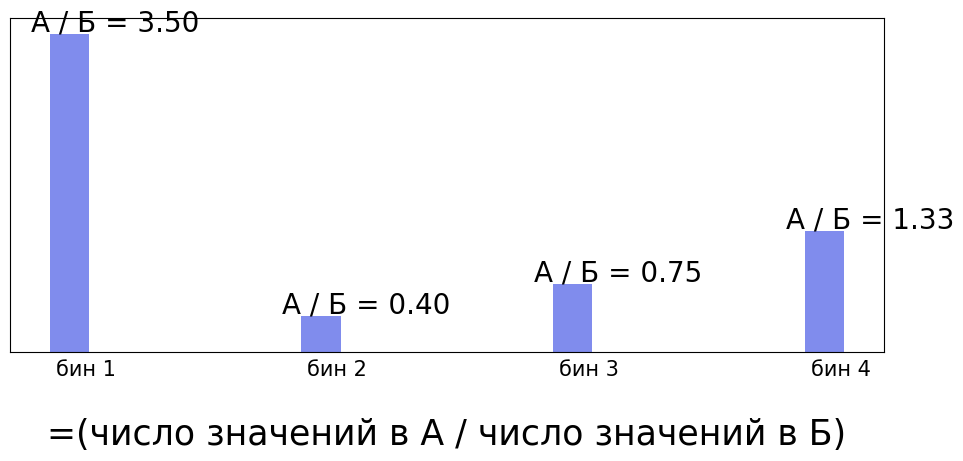

In [58]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('=(число значений в А / число значений в Б)', fontsize=25, y=-0.3)
plt.bar(
    bins[: -1]+0.0346
    , (cnt_a[0] / cnt_b[0])
    , color='#808CED'
    , width=[shift] * (len(bins)-1)
    , alpha=1
    , label='bin_1 - bin_2'
)

for idx, diff in enumerate((cnt_a[0] / cnt_b[0])):
    plt.text(
        x=bins[idx]
        , y=(cnt_a[0] / cnt_b[0])[idx] + 0.03
        , s=f"А / Б = {diff:0.2f}"
        , fontsize=20
    )

for i in range(len(bins) - 1):
    ax.text(np.mean([bins[i], bins[i + 1]])-0.09, -0.25, f'бин {i+1}')

plt.xticks([])
plt.yticks([])
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
plt.grid(False)
plt.tight_layout()
plt.savefig('../pictures/psi_5.png', dpi=100, format='png')

Делим количество наблюдений бина А на количество наблюдений в бине Б, 

### Третий шаг в расчете PSI
- По формуле высчитываем значение PSI


$PSI = \sum{}\Big(\big(Actual \% - Expected \%\big) \times ln\big(\dfrac{Actual \%}{Expected \%}\big)\Big)$

In [48]:
# отнормируем число значений в бине к 1
cnt_a = [cnt_a[0] / sum(cnt_a[0])]
cnt_b = [cnt_b[0] / sum(cnt_b[0])]

In [49]:
# итоговый PSI
np.sum([
    diff * np.log(div) for (div, diff) in (
        zip(
            [(0.0001 if ((i == 0) | (i == float('inf'))) else i) for i in (cnt_a[0] / cnt_b[0])], 
            [(0.0001 if ((i == 0) | (i == float('inf'))) else i) for i in (cnt_a[0] - cnt_b[0])], 
        )
    )
])

0.7212430829725472

### или альтернативный подход

In [50]:
bucket_edges = np.linspace(
    min(np.min(arr_a), np.min(arr_b))
    , max(np.max(arr_a), np.max(arr_b))
    , n_bins+1
)

In [51]:
expected_hist, _ = np.histogram(arr_a, bins=bucket_edges)
actual_hist, _ = np.histogram(arr_b, bins=bucket_edges)

expected_hist = expected_hist / sum(expected_hist)
actual_hist = actual_hist / sum(actual_hist)

In [52]:
# итоговый PSI
np.sum([
    diff * np.log(div) for (div, diff) in (
        zip(

            [(0.0001 if ((i == 0) | (i == float('inf'))) else i) for i in (expected_hist / actual_hist)], 
            [(0.0001 if ((i == 0) | (i == float('inf'))) else i) for i in (expected_hist - actual_hist)], 
        )
    )
])

0.7212430829725472

# Критерий Колмогорова-Смирнова

In [16]:
# задаем начальные распределения
arr_a = (beta.rvs(1, 3, 0, size=31))  # исходное распределение А
arr_b = (beta.rvs(2, 5, 0, size=31))  # исходное распределение Б

n_bins = 7
bins = np.linspace(min(arr_a.min(), arr_b.min()), max(arr_a.max(), arr_b.max()), n_bins+1)

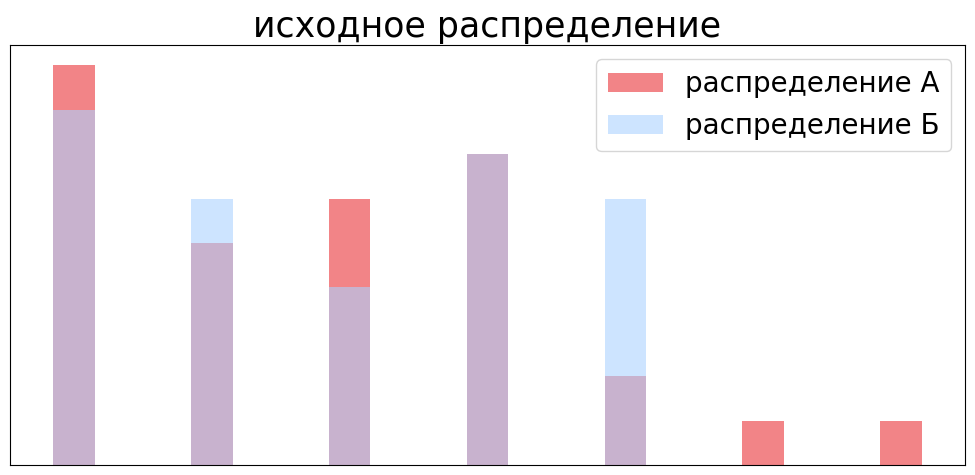

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axes.set_yticks([])
ax.axes.set_xticks([])

plt.hist(
    arr_a
    , bins=bins
    , color='#EA3338'
    , rwidth=0.3
    , label='распределение А'
    , alpha=0.6
)

plt.hist(
    arr_b
    , bins=bins
    , color='#ADD2FF'
    , rwidth=0.3
    , label='распределение Б'
    , alpha=0.6
)

plt.title('исходное распределение', y=1., fontsize=25)

plt.grid(False)
plt.legend(fontsize=20)

plt.tight_layout()
plt.show()

### Первый шаг в расчете критерия Колмогорова-Смирнова

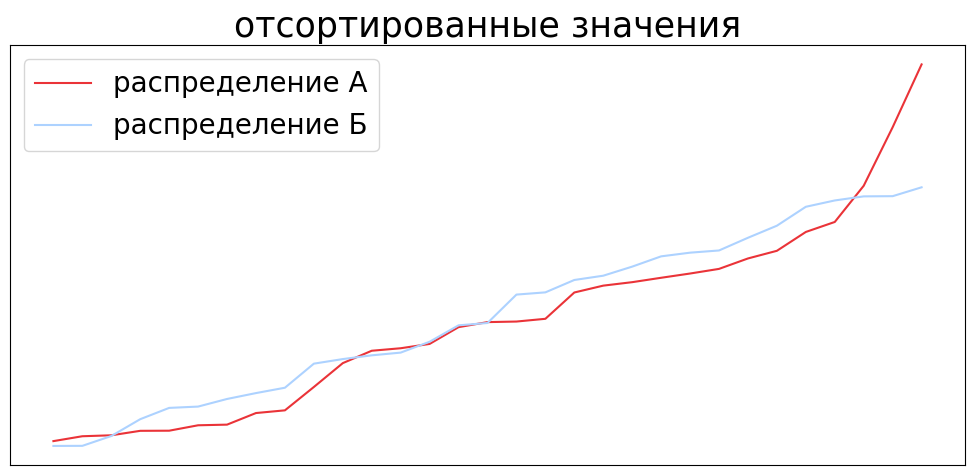

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('отсортированные значения', y=1., fontsize=25)

a_ = np.sort(arr_a)
b_ = np.sort(arr_b)

plt.plot(a_, label='распределение А', color='#EA3338')
plt.plot(b_, label='распределение Б', color='#ADD2FF')

plt.legend(fontsize=20)
plt.grid(False)
plt.yticks([])
plt.xticks([])

plt.tight_layout()
plt.show()

### Второй шаг в расчете критерия Колмогорова-Смирнова
Приводим распределение А к распределению Б или наоборот - распределение Б к распределению А. (зависит от проверяемой гипотезы) Делается это через бининг по значениям одного из распределений.

In [19]:
a_to_b = np.searchsorted(sorted(arr_a), sorted(arr_b), side='right') / len(arr_a)
b_to_b = np.searchsorted(sorted(arr_b), sorted(arr_b), side='right') / len(arr_b)
idx_max_1 = np.argmax(abs(a_to_b - b_to_b))
idx_min_1 = np.argmax(-(a_to_b - b_to_b))

b_to_a = np.searchsorted(sorted(arr_b), sorted(arr_a), side='right') / len(arr_b)
a_to_a = np.searchsorted(sorted(arr_a), sorted(arr_a), side='right') / len(arr_a)
idx_max_2 = np.argmax(abs(b_to_a - a_to_a))
idx_min_2 = np.argmax(-(a_to_a-b_to_a))

Здесь используется функция np.searchsorted, которая находит индексы, куда элементы из одного массива (например, sorted(arr_b)) должны быть вставлены в другой отсортированный массив (например, sorted(arr_a)) для сохранения порядка.
- a_to_b показывает, где элементы из arr_b должны быть вставлены в arr_a.
- b_to_b показывает, где элементы из arr_b должны быть вставлены в сам arr_b.


Деление на длину массива нормализует значения, приводя их к диапазону от 0 до 1. Это позволяет сравнивать CDF (функции распределения) двух массивов.

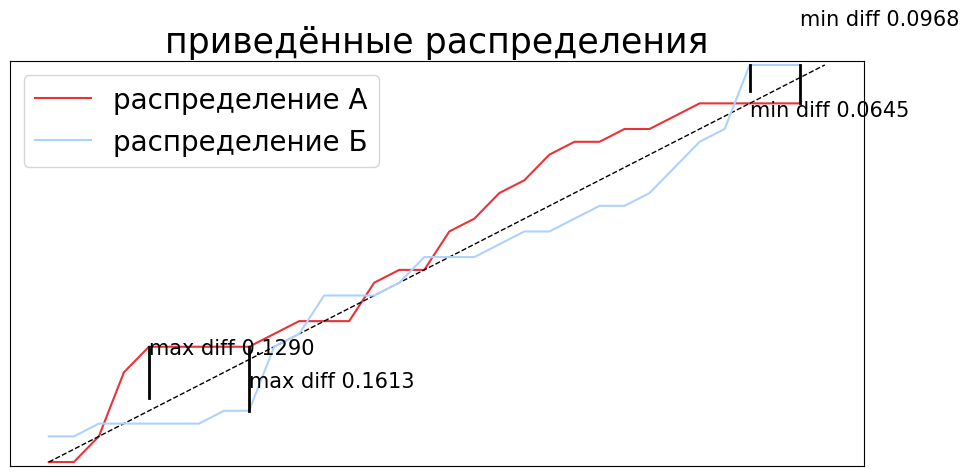

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('приведённые распределения', y=1., fontsize=25)

plt.plot(a_to_b, label='распределение А', color='#EA3338')

plt.plot([0, len(a_to_b)], [0, 1], color='black', linestyle='--', linewidth=1)

plt.plot(b_to_a, label='распределение Б', color='#ADD2FF')


# greater
plt.plot([idx_max_2, idx_max_2], [b_to_b[idx_max_2], b_to_a[idx_max_2]], color='black', linewidth=2)
plt.plot([idx_max_1, idx_max_1], [b_to_b[idx_max_1], a_to_b[idx_max_1]], color='black', linewidth=2)

plt.text(idx_max_1, np.mean([b_to_b[idx_max_1], a_to_b[idx_max_1]])*1.2, s=f'max diff {max(abs(a_to_b - b_to_b)):0.4f}')
plt.text(idx_max_2, np.mean([a_to_a[idx_max_2], b_to_a[idx_max_2]])*0.9, s=f'max diff {max(abs(b_to_a - a_to_a)):0.4f}')


# less
plt.plot([idx_min_1, idx_min_1], [a_to_b[idx_min_1], b_to_b[idx_min_1]], color='black', linewidth=2)
plt.plot([idx_min_2, idx_min_2], [a_to_a[idx_min_2], b_to_a[idx_min_2]], color='black', linewidth=2)

plt.text(idx_min_1, np.mean([a_to_a[idx_min_1], b_to_b[idx_min_1]])*1.1, s=f'min diff {max(-(a_to_b - a_to_a)):0.4f}')
plt.text(idx_min_2, np.mean([a_to_a[idx_min_2], b_to_a[idx_min_2]])*0.9, s=f'min diff {max(-(b_to_b - b_to_a)):0.4f}')

plt.legend(fontsize=20, loc='upper left')

plt.ylim(-0.01, 1.01)
plt.grid(False)
plt.yticks([])
plt.xticks([])

plt.tight_layout()
plt.show()

In [21]:
# то, что мы посчитали сами
print(round(max(abs(b_to_a - a_to_a)), 4), round(max(abs(a_to_b - b_to_b)), 4))

0.1613 0.129


In [22]:
# то, что мы посчитали сами (less)
print(round(min(max(-(a_to_b - b_to_b)), max(-(b_to_a - a_to_a))), 4))

0.0968


In [23]:
# сравнение с scipy
print(round(kstest(arr_a, arr_b, alternative='less').statistic, 4))
print(round(kstest(arr_a, arr_b, alternative='greater').statistic, 4))

0.0968
0.1613


# Adversarial Validation Score

In [24]:
arr_a = (beta.rvs(1, 2, 0, size=21))      # исходное распределение А
arr_b = (beta.rvs(1.9, 2.6, 0, size=21))  # исходное распределение Б

n_bins = 7
bins = np.linspace(min(arr_a.min(), arr_b.min()), max(arr_a.max(), arr_b.max()), n_bins+1)

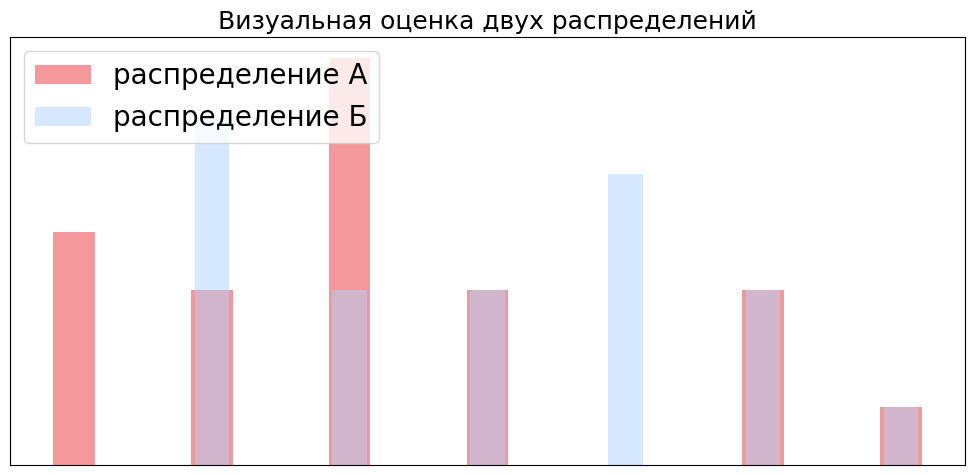

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axes.set_yticks([])
ax.axes.set_xticks([])

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

shift = 0.035

cnt_a = plt.hist(arr_a, bins=bins, color='#EA3338', rwidth=0.3, label='распределение А', alpha=0.5)
cnt_b = plt.hist(arr_b, bins=bins, color='#ADD2FF', rwidth=0.25, label='распределение Б', alpha=0.5)

plt.yticks([])
plt.xticks([])
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

plt.grid(False)
plt.tight_layout()
plt.legend(fontsize=20, loc='upper left')
plt.title('Визуальная оценка двух распределений')

plt.tight_layout()
plt.show()

### Первый шаг в расчете adversarial validation score

In [26]:
target = np.hstack([np.ones(arr_a.shape[0]), np.zeros(arr_b.shape[0])])
X = np.hstack([arr_a, arr_b]).reshape(-1, 1)

### Второй шаг в расчете adversarial validation score

In [27]:
np.mean(
    cross_val_score(
        estimator=DecisionTreeClassifier(max_depth=3, random_state=1)
        , X=X
        , y=target
        , cv=5
        , scoring='roc_auc'
    )
)

0.83375

### Смотрим на более непохожее распределение

In [28]:
arr_a = (beta.rvs(1, 2, 0, size=21))  # исходное распределение А
arr_b = (beta.rvs(7, 8, 0, size=21))  # исходное распределение Б

n_bins = 7
bins = np.linspace(min(arr_a.min(), arr_b.min()), max(arr_a.max(), arr_b.max()), n_bins+1)

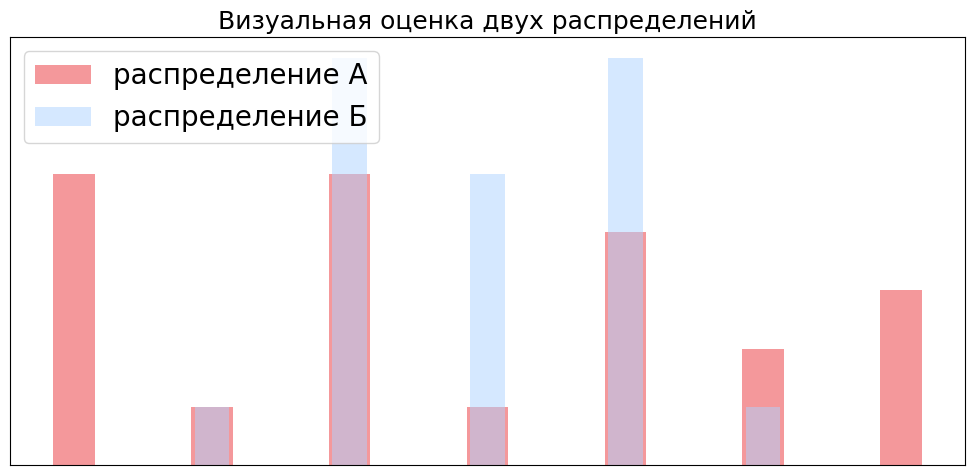

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.axes.set_yticks([])
ax.axes.set_xticks([])

fig.patch.set_facecolor('white')
ax.set_facecolor('white')

shift = 0.035

cnt_a = plt.hist(arr_a, bins=bins, color='#EA3338', rwidth=0.3, label='распределение А', alpha=0.5)
cnt_b = plt.hist(arr_b, bins=bins, color='#ADD2FF', rwidth=0.25, label='распределение Б', alpha=0.5)

plt.yticks([])
plt.xticks([])
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

plt.grid(False)
plt.tight_layout()
plt.legend(fontsize=20, loc='upper left')
plt.title('Визуальная оценка двух распределений')

plt.tight_layout()
plt.show()

In [30]:
target = np.hstack([np.ones(arr_a.shape[0]), np.zeros(arr_b.shape[0])])
X = np.hstack([arr_a, arr_b]).reshape(-1, 1)

In [31]:
np.mean(
    cross_val_score(
        estimator=DecisionTreeClassifier(max_depth=3, random_state=1)
        , X=X
        , y=target
        , cv=5
        , scoring='roc_auc'
    )
)

0.6537499999999999

In [32]:
# well done